In [16]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

#Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(80, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = 10 # Only use 10 images for training




Loading 80 images
satImage_052.png
Loading 80 images
satImage_052.png


In [196]:
# Extract patches from input images
patch_size = 100 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
# print(len(img_crop(imgs[0],patch_size,patch_size)))
# print(len(img_patches))
# print(len(img_patches[0]))
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
# print(len(img_patches))
print(img_patches.shape)

(1280, 100, 100, 3)


In [197]:
image_dataset = np.array(img_patches)
mask_dataset = np.array(gt_patches)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)


#scaler = MinMaxScaler()
#mask_dataset = scaler.fit_transform(mask_dataset.reshape(-1, mask_dataset.shape[-1])).reshape(mask_dataset.shape)

In [199]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Max pixel value in mask is: ", mask_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1280, 100, 100, 3)
Mask data shape is:  (1280, 100, 100, 1)
Max pixel value in image is:  1.0
Max pixel value in mask is:  0.92941177
Labels in the mask are :  [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

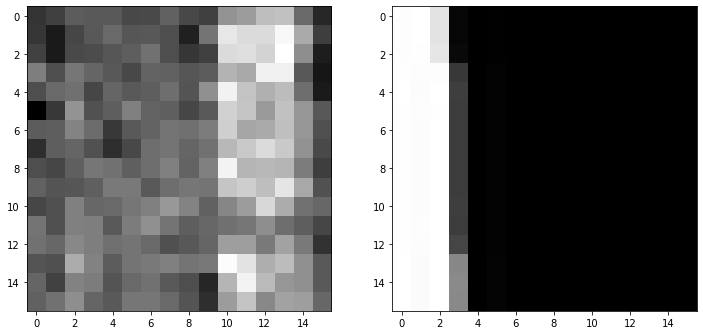

In [66]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [183]:
#2eme essai
#Batch norm between convolutions

def encode(inputs,filter_n, max_pooling=True):
    filter= 8
    c1= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , padding = 'same') (inputs)
    b1= tf.keras.layers.BatchNormalization()(c1)
    l1 = keras.layers.LeakyReLU(0)(b1)
    c2= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , padding = 'same') (l1)
    b2= tf.keras.layers.BatchNormalization()(c2)
    l2 = keras.layers.LeakyReLU(0)(b2)
    if max_pooling :
        m1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(l2)
    else :
        m1=0
    return l2, m1


def decode(inputs_1, inputs_2, filter_n): 
    filter = 8
    ct1 = tf.keras.layers.Conv2DTranspose(filters= filter*filter_n , kernel_size = 3,strides = (2,2), padding = 'same')(inputs_1)
    b1= tf.keras.layers.BatchNormalization()(ct1)
    ccat1= tf.keras.layers.concatenate([b1, inputs_2])
    c1= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , padding = 'same') (ccat1)
    b2= tf.keras.layers.BatchNormalization()(c1)
    l1 = keras.layers.LeakyReLU(0)(b2)
    c2= tf.keras.layers.Conv2D(filters = filter*filter_n, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') (l1)
    b3= tf.keras.layers.BatchNormalization()(c2)
    l2 = keras.layers.LeakyReLU(0)(b3)

    return l2


def unet_model(input_size = (16,16,3)):
    inputs = Input(input_size)

    #encode
    b1, m1 = encode(inputs,1,  max_pooling = True)
    b2, m2 = encode(m1, 2,  max_pooling = True)
    b3, m3 = encode(m2, 4,  max_pooling = True)
    b4 , m4 = encode(m3, 8, max_pooling = True)
    b5, m5 = encode(m4,16, max_pooling = False)

    #decode
    d1= decode(b5,b4, 8)
    d2 = decode(d1,b3, 4)
    d3 = decode(d2,b2, 2)
    d4 = decode(d3,b1, 1)

    #output
    output_layer= tf.keras.layers.Conv2D(filters=1 ,kernel_size =1, activation = 'sigmoid')(d4)
    
    model = Model(inputs = [inputs], outputs = [output_layer])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,loss = 'binary_crossentropy', metrics=['Precision', 'Recall', 'accuracy'])

    model.summary()
    return model

model = unet_model()



Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d_247 (Conv2D)            (None, 16, 16, 8)    224         ['input_14[0][0]']               
                                                                                                  
 batch_normalization_156 (Batch  (None, 16, 16, 8)   32          ['conv2d_247[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_36 (LeakyReLU)     (None, 16, 16, 8)    0           ['batch_normalization_156[

In [190]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
313/313 [==============================] - 21s 68ms/step - loss: 0.4088 - precision: 0.1125 - recall: 6.2439e-04 - accuracy: 0.8139 - val_loss: 0.3965 - val_precision: 0.0349 - val_recall: 4.6583e-05 - val_accuracy: 0.7985
Epoch 2/20
313/313 [==============================] - 20s 65ms/step - loss: 0.3890 - precision: 0.1120 - recall: 3.5860e-04 - accuracy: 0.8143 - val_loss: 0.3860 - val_precision: 0.0449 - val_recall: 6.2111e-05 - val_accuracy: 0.7985
Epoch 3/20
313/313 [==============================] - 20s 65ms/step - loss: 0.3739 - precision: 0.1202 - recall: 3.0376e-04 - accuracy: 0.8144 - val_loss: 0.3883 - val_precision: 0.1111 - val_recall: 1.5528e-05 - val_accuracy: 0.7987
Epoch 4/20
313/313 [==============================] - 20s 64ms/step - loss: 0.3557 - precision: 0.1065 - recall: 1.5188e-04 - accuracy: 0.8146 - val_loss: 0.3779 - val_precision: 0.0250 - val_recall: 1.5528e-05 - val_accuracy: 0.7986
Epoch 5/20
313/313 [==============================] - 22s 69ms/s

In [185]:
#Save the model for future use
model.save("Saved_models/")

INFO:tensorflow:Assets written to: Saved_models/assets


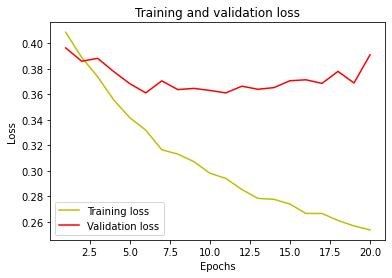

In [191]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


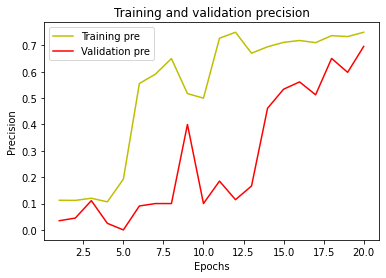

In [194]:
pre= history.history['precision']
val_pre = history.history['val_precision']
plt.plot(epochs, pre, 'y', label='Training pre')
plt.plot(epochs, val_pre, 'r', label='Validation pre')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

#overfitting

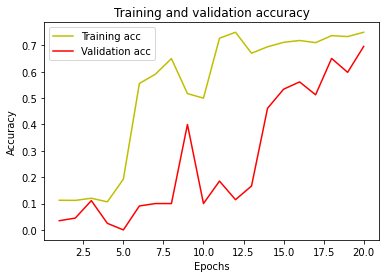

In [193]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, pre, 'y', label='Training acc')
plt.plot(epochs, val_pre, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#overfitting

In [139]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [140]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.43012345


(1, 16, 16, 3)
(16, 16)


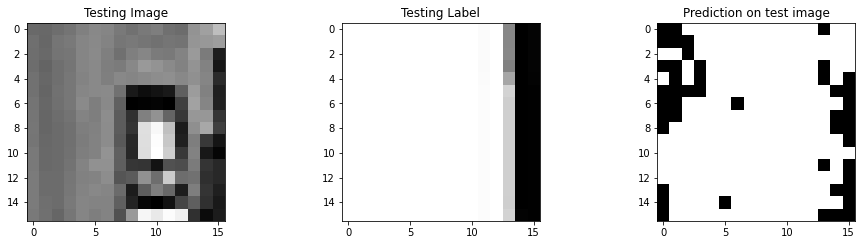

In [170]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()